# Import Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import multiprocessing

import pickle
import catboost as cb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)

# Set Random State

In [2]:
global rand_state
rand_state = 2023

# Utility Functions

In [22]:
def get_mean_cvs(model, X, y):
    global rand_state
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    
    print(f'Cross Validation Accuracy Score: {scores.mean():.3f} ({scores.std():.3f})')
    
    return scores


def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['High Shares', 'Average Shares', 'Low Shares']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=labels)

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                      color='w' if cm[i,j] > threshold else 'black',
                      fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3, 
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None, 
                                 scoring='accuracy', 
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f'{mean} ({stdev}) with: {param}')
    print("Best Parameters: " +  str(grid_result.best_params_))
        
    return grid_result

# Load Dataset

In [4]:
X_train = pd.read_csv('./dataset/SmartLocal/X_train.csv')
y_train = pd.read_csv('./dataset/SmartLocal/y_train.csv')

X_test = pd.read_csv('./dataset/SmartLocal/X_test.csv')
y_test = pd.read_csv('./dataset/SmartLocal/y_test.csv')

# Scaling Data

In [ ]:
# Gradient descent and distance-based algorithms require feature scaling while tree-based algorithms do not.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 1. Gradient Boosting

## 1.1 CatBoost

{'verbose': False, 'random_state': 2023, 'objective': 'MultiClass'}
Cross Validation Accuracy Score: 0.474 (0.030)
                precision    recall  f1-score   support

   High Shares       0.40      0.35      0.38       283
Average Shares       0.50      0.57      0.53       245
    Low Shares       0.51      0.51      0.51       271

      accuracy                           0.47       799
     macro avg       0.47      0.48      0.47       799
  weighted avg       0.47      0.47      0.47       799



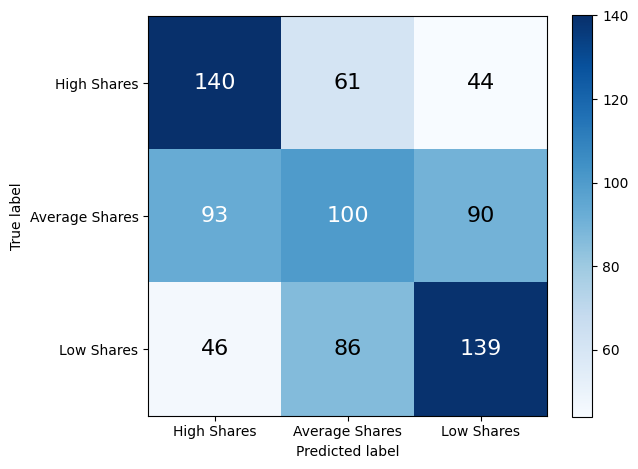

In [48]:
cb_base_model = cb.CatBoostClassifier(
    objective='MultiClass', 
    random_state=rand_state, 
    verbose=False
)
print(cb_base_model.get_params())

get_mean_cvs(cb_base_model, X_train, y_train)

cb_base_model.fit(X_train, y_train, verbose=False)
y_pred_cb_base = cb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_base)

{'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 3, 'verbose': False, 'n_estimators': 140, 'random_state': 2023, 'objective': 'MultiClass'}
Cross Validation Accuracy Score: 0.483 (0.026)
                precision    recall  f1-score   support

   High Shares       0.37      0.25      0.30       283
Average Shares       0.49      0.56      0.52       245
    Low Shares       0.47      0.56      0.51       271

      accuracy                           0.45       799
     macro avg       0.44      0.46      0.44       799
  weighted avg       0.44      0.45      0.44       799



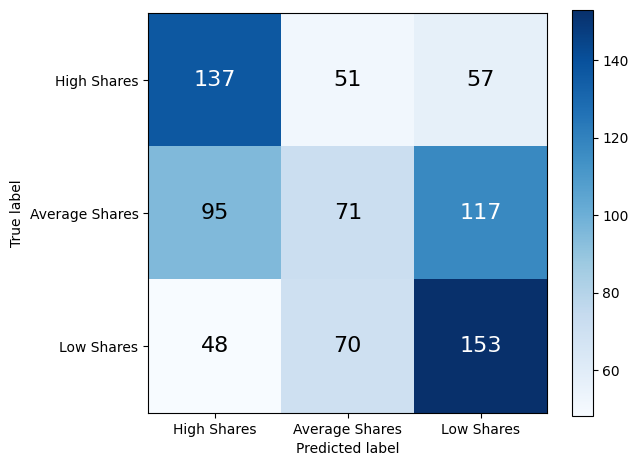

In [49]:
cb_GS = GridSearchCV(
    cb.CatBoostClassifier(objective='MultiClass', random_state=rand_state, verbose=False), 
    {
        'depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'l2_leaf_reg': [1, 3, 5],
    }, 
    n_jobs=multiprocessing.cpu_count())

cb_GS = cb_GS.fit(X_train, y_train)

cb_best_model = cb_GS.best_estimator_
print(cb_best_model.get_params())

get_mean_cvs(cb_best_model, X_train, y_train)

cb_best_model.fit(X_train, y_train)
y_pred_cb_best = cb_best_model.predict(X_test)
evaluate_model(y_test, y_pred_cb_best)

In [62]:
pickle.dump(cb_best_model, open('./dataset/Model/cb_best_model.pkl', 'wb'))

## 1.2 LightGBM

LGBMClassifier(objective='accuracy', random_state=2023)
Cross Validation Accuracy Score: 0.467 (0.030)
                precision    recall  f1-score   support

   High Shares       0.37      0.31      0.34       283
Average Shares       0.47      0.56      0.51       245
    Low Shares       0.51      0.51      0.51       271

      accuracy                           0.45       799
     macro avg       0.45      0.46      0.45       799
  weighted avg       0.45      0.45      0.45       799



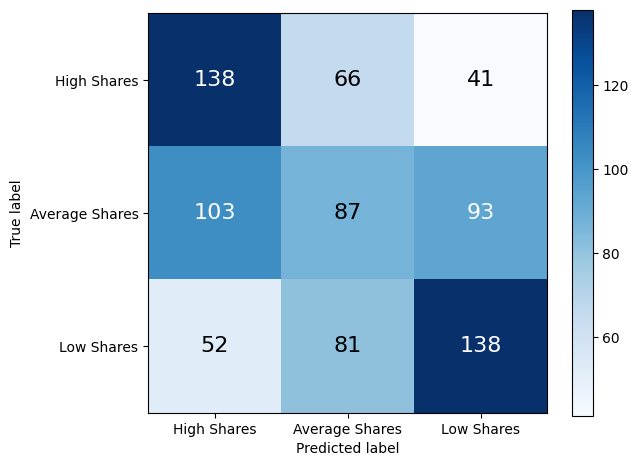

In [44]:
lgb_base_model = lgb.LGBMClassifier(
    objective='accuracy', 
    random_state=rand_state
)
print(lgb_base_model)

get_mean_cvs(lgb_base_model, X_train, y_train.to_numpy().ravel())

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_base = lgb_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

LGBMClassifier(max_depth=2, num_leaves=10, objective='accuracy',
               random_state=2023, subsample=0.5)
Cross Validation Accuracy Score: 0.483 (0.025)
                precision    recall  f1-score   support

   High Shares       0.39      0.28      0.32       283
Average Shares       0.48      0.55      0.51       245
    Low Shares       0.50      0.57      0.53       271

      accuracy                           0.46       799
     macro avg       0.45      0.47      0.46       799
  weighted avg       0.45      0.46      0.45       799



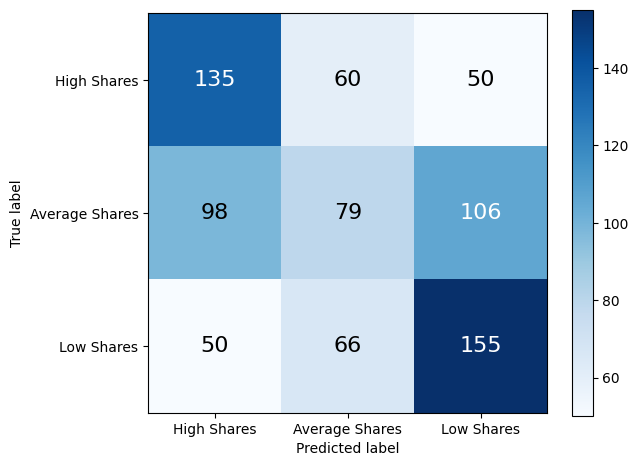

In [42]:
lgb_GS = GridSearchCV(
    lgb.LGBMClassifier(objective='accuracy', random_state=rand_state), 
    {
        'max_depth': [2, 5, 10],
        'n_estimators': [60, 100, 140],
        'learning_rate': [0.1, 0.01],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 0.9], 
    }, 
    n_jobs=multiprocessing.cpu_count())

lgb_GS = lgb_GS.fit(X_train, y_train.to_numpy().ravel())

lgb_best_model = lgb_GS.best_estimator_
print(lgb_best_model)

get_mean_cvs(lgb_best_model, X_train, y_train.to_numpy().ravel())

lgb_base_model.fit(X_train, y_train)
y_pred_lgb_best = lgb_best_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_best)

In [63]:
pickle.dump(lgb_best_model, open('./dataset/Model/lgb_best_model.pkl', 'wb'))

## 1.3 Adaboost

AdaBoostClassifier(random_state=2023)
Cross Validation Accuracy Score: 0.471 (0.028)
                precision    recall  f1-score   support

   High Shares       0.37      0.26      0.31       283
Average Shares       0.45      0.56      0.50       245
    Low Shares       0.50      0.55      0.52       271

      accuracy                           0.45       799
     macro avg       0.44      0.46      0.44       799
  weighted avg       0.44      0.45      0.44       799



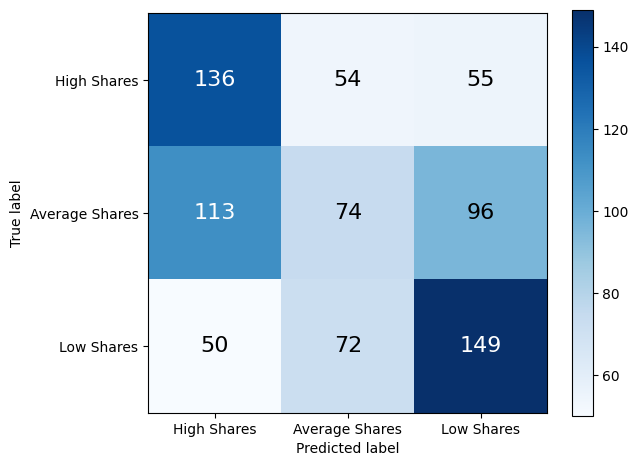

In [51]:
ada_base_model = AdaBoostClassifier(
    random_state=rand_state
)
print(ada_base_model)

get_mean_cvs(ada_base_model, X_train, y_train.to_numpy().ravel())

ada_base_model.fit(X_train, y_train)
y_pred_lgb_base = ada_base_model.predict(X_test)
evaluate_model(y_test, y_pred_lgb_base)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=2023)
Cross Validation Accuracy Score: 0.485 (0.029)
                precision    recall  f1-score   support

   High Shares       0.41      0.28      0.33       283
Average Shares       0.52      0.57      0.54       245
    Low Shares       0.46      0.58      0.52       271

      accuracy                           0.47       799
     macro avg       0.46      0.48      0.46       799
  weighted avg       0.46      0.47      0.46       799



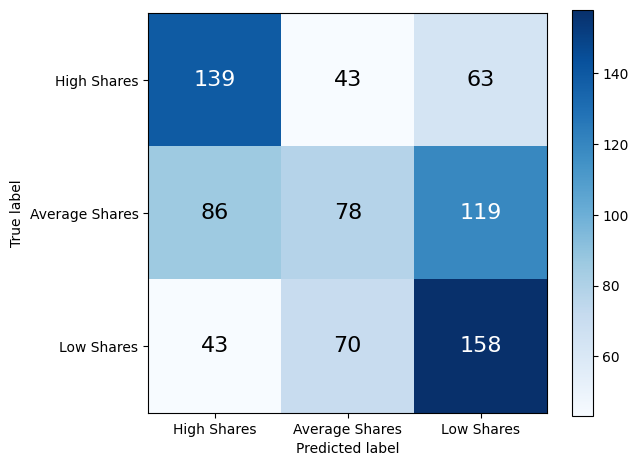

In [65]:
ada_GS = GridSearchCV(
    AdaBoostClassifier(random_state=rand_state), 
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }, 
    n_jobs=multiprocessing.cpu_count())

ada_GS = ada_GS.fit(X_train, y_train.to_numpy().ravel())

ada_best_model = ada_GS.best_estimator_
print(ada_best_model)

get_mean_cvs(ada_best_model, X_train, y_train.to_numpy().ravel())

lgb_base_model.fit(X_train, y_train)
y_pred_ada_best = ada_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ada_best)

In [66]:
pickle.dump(ada_best_model, open('./dataset/Model/ada_best_model.pkl', 'wb'))

In [ ]:
ab_base_model =  AdaBoostClassifier(n_estimators=100, random_state=rand_state)
get_mean_cvs(ab_base_model, X_train, y_train)

Cross Validation Accuracy Score: 0.465 (0.028)


array([0.4375    , 0.453125  , 0.45625   , 0.44514107, 0.45454545,
       0.45454545, 0.47335423, 0.44827586, 0.46081505, 0.49216301,
       0.478125  , 0.4625    , 0.453125  , 0.49529781, 0.54231975,
       0.44200627, 0.42946708, 0.43887147, 0.42946708, 0.47962382,
       0.4625    , 0.453125  , 0.45      , 0.49216301, 0.50783699,
       0.4200627 , 0.48902821, 0.44827586, 0.4984326 , 0.51410658])

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                precision    recall  f1-score   support

   High Shares       0.39      0.31      0.34       283
Average Shares       0.47      0.56      0.51       245
    Low Shares       0.49      0.51      0.50       271

      accuracy                           0.45       799
     macro avg       0.45      0.46      0.45       799
  weighted avg       0.45      0.45      0.45       799



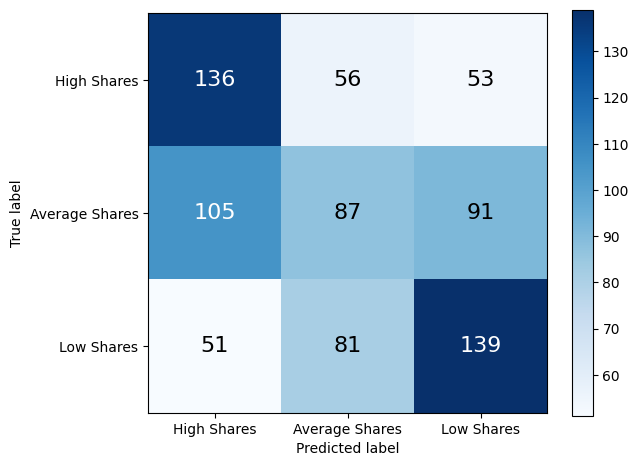

In [ ]:
ab_base_model.fit(X_train, y_train)
y_pred_ab_base = ab_base_model.predict(X_test)
evaluate_model(y_test, y_pred_ab_base)

In [ ]:
params = {"n_estimators": [25,50,100,200],
          "learning_rate": [0.01, 0.1, 1.0]
          }

ab_model =  AdaBoostClassifier()

ab_best_params = get_best_params(model=ab_model,
                                 grid=params,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: -1.0541577301039349 using {'n_estimators': 50, 'learning_rate': 0.01}
-1.0740981043462114 (0.001215878723778299) with: {'n_estimators': 50, 'learning_rate': 0.1}
-1.087260565245316 (0.001277844542557686) with: {'n_estimators': 25, 'learning_rate': 1.0}
-1.056803517977993 (0.0034705064728782708) with: {'n_estimators': 100, 'learning_rate': 0.01}
-1.0553976568272914 (0.009253704438363554) with: {'n_estimators': 25, 'learning_rate': 0.01}
-1.0926319435296699 (0.0013598535052255936) with: {'n_estimators': 100, 'learning_rate': 1.0}
-1.0629088276738767 (0.0023147464201517293) with: {'n_estimators': 200, 'learning_rate': 0.01}
-1.06488918359689 (0.0020278361933582364) with: {'n_estimators': 25, 'learning_rate': 0.1}
-1.0541577301039349 (0.005523629009765593) with: {'n_estimators': 50, 'learning_rate': 0.01}
-1.0948652574299433 (0.0008726738173769893) with: {'n_estimators': 200, 'learning_rate': 1.0}
-1.081502563637835 (0.0009455889552752935) with: {'n_estimators': 100, 'learning_rate':

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision an

                precision    recall  f1-score   support

   High Shares       0.00      0.00      0.00       283
Average Shares       0.41      0.67      0.51       245
    Low Shares       0.44      0.65      0.52       271

      accuracy                           0.43       799
     macro avg       0.28      0.44      0.34       799
  weighted avg       0.28      0.43      0.33       799



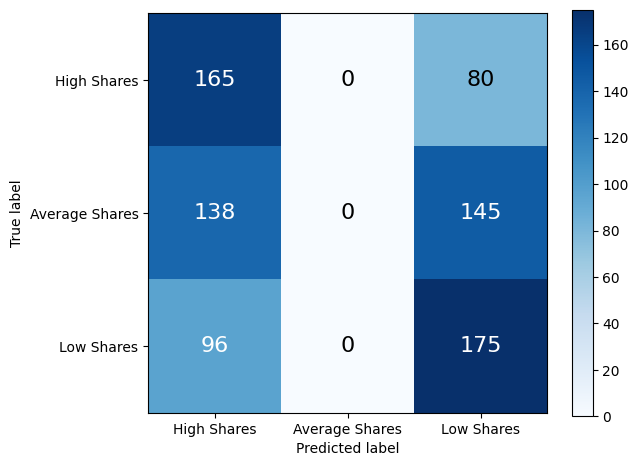

In [ ]:
# Parameters to be tuned (Runtime at 2h20mins)
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Placing parameters into a dictionary
parameters= {
    'max_features': max_features,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}
ab_best_model = AdaBoostClassifier(n_estimators = 50, learning_rate = 0.01).fit(X_train, y_train)
y_pred_ab_best = ab_best_model.predict(X_test)
evaluate_model(y_test, y_pred_ab_best)

In [ ]:
ab_best_model.feature_names_in_

array(['timedelta', 'n_tokens_title', 'n_tokens_preview',
       'preview_subjectivity', 'n_tokens_content', 'prop_non_stop',
       'prop_unique_non_stop', 'num_imgs', 'num_hrefs', 'n_tokens_cross',
       'subjectivity_cross', 'content_cross', 'subcategory1_Attractions',
       'subcategory1_Australia', 'subcategory1_Beauty & Wellness',
       'subcategory1_Food Guides', 'subcategory1_Malaysia',
       'subcategory1_Sales & Promotions',
       'author_category_100 to 200 posts',
       'author_category_More than 200 posts', '0', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '0.1', '1.1', '2.1', '3.1', '4.1', '5.1',
       '6.1', '7.1', '8.1', '9.1', '0.2', '1.2', '2.2', '3.2', '4.2',
       '5.2', '6.2', '7.2', '8.2', '9.2'], dtype=object)

In [ ]:

pd.DataFrame({'feature': ab_best_model.feature_names_in_, 'score': ab_best_model.feature_importances_}).set_index('feature').squeeze().sort_values(ascending = False)[:10]

feature
timedelta    0.60
num_imgs     0.34
0.1          0.06
8.1          0.00
8            0.00
9            0.00
1.1          0.00
2.1          0.00
3.1          0.00
4.1          0.00
Name: score, dtype: float64

In [ ]:
evaluate_model(y_test, y_pred_ab_base)

# 3. Random Forest


In [ ]:
mapping = {"Low Shares": 0, "Average Shares": 1, "High Shares": 2}

y_train['num_shares_bin'] = y_train['num_shares_bin'].map(mapping)
y_test['num_shares_bin'] = y_test['num_shares_bin'].map(mapping)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


rf = RandomForestClassifier()
np.random.seed(rand_state)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

<ipython-input-21-e4a8a26ae20a>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.49      0.51      0.50       271
           1       0.41      0.37      0.39       283
           2       0.48      0.52      0.50       245

    accuracy                           0.46       799
   macro avg       0.46      0.47      0.46       799
weighted avg       0.46      0.46      0.46       799



# 4. Convolutional Neural Network

In [ ]:
X_train = pd.read_csv('./drive/My Drive/IS4242/datasets/X_train.csv')
y_train = pd.read_csv('./drive/My Drive/IS4242/datasets/y_train.csv')

X_test = pd.read_csv('./drive/My Drive/IS4242/datasets/X_test.csv')
y_test = pd.read_csv('./drive/My Drive/IS4242/datasets/y_test.csv')

In [ ]:
mapping = {"Low Shares": 0, "Average Shares": 1, "High Shares": 2}

y_train['num_shares_bin'] = y_train['num_shares_bin'].map(mapping)
y_test['num_shares_bin'] = y_test['num_shares_bin'].map(mapping)

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
import tensorflow
from tensorflow.keras.utils import to_categorical
# Reshape X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape y_train and y_test
# One-hot encode target variables
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)


In [ ]:
print(X_train.shape)
print(y_train_encode.shape)
print(X_test.shape)
print(y_test_encode.shape)

(3193, 50, 1)
(3193, 3)
(799, 50, 1)
(799, 3)


In [ ]:
# Import necessary libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import tensorflow as tf

tf.keras.utils.set_random_seed(1)

# Build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=2,padding="same", activation="linear"))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Conv1D(32, kernel_size=2,padding="same", activation="linear"))
model.add(MaxPooling1D(pool_size=2, padding="same"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encode, epochs=25, batch_size=32, validation_data=(X_test, y_test_encode))


Epoch 1/25
100/100 [==============================] - 3s 18ms/step - loss: 6062.0186 - accuracy: 0.3276 - val_loss: 2420.8489 - val_accuracy: 0.3542
Epoch 2/25
100/100 [==============================] - 1s 14ms/step - loss: 2133.2334 - accuracy: 0.3288 - val_loss: 196.6582 - val_accuracy: 0.3392
Epoch 3/25
100/100 [==============================] - 1s 14ms/step - loss: 1103.0475 - accuracy: 0.3342 - val_loss: 246.6437 - val_accuracy: 0.3079
Epoch 4/25
100/100 [==============================] - 1s 15ms/step - loss: 660.2885 - accuracy: 0.3451 - val_loss: 119.7515 - val_accuracy: 0.3066
Epoch 5/25
100/100 [==============================] - 2s 16ms/step - loss: 405.5176 - accuracy: 0.3276 - val_loss: 65.4854 - val_accuracy: 0.3579
Epoch 6/25
100/100 [==============================] - 2s 22ms/step - loss: 230.8657 - accuracy: 0.3335 - val_loss: 27.8691 - val_accuracy: 0.3517
Epoch 7/25
100/100 [==============================] - 3s 31ms/step - loss: 131.4828 - accuracy: 0.3398 - val_loss: 2

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on test data
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test.flatten(), y_pred))

25/25 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.41      0.73      0.52       271
           1       0.35      0.37      0.36       283
           2       0.61      0.04      0.08       245

    accuracy                           0.39       799
   macro avg       0.46      0.38      0.32       799
weighted avg       0.45      0.39      0.33       799



# Model Evaluation